# Characterisation and reprogramming of bacteriophage mv4 integrase recombination specificity

---
##### Kevin Debatisse<sup>1</sup>, Pierre Lopez<sup>1</sup>, Maryse Poli<sup>1</sup>, Philippe Rousseau<sup>2,3</sup>, Manuel Campos<sup>2,3</sup>, Michèle Coddeville<sup>2,3</sup>, Muriel Cocaign-Bousquet<sup>1</sup> and Pascal Le Bourgeois<sup>1,3,*</sup>
---

1 TBI, Université de Toulouse, CNRS, INRAE, INSA, Toulouse, France

2 CBI, LMGM, Université de Toulouse, CNRS, Toulouse, France

3 Université Toulouse III - Paul Sabatier, Toulouse, France
 



---
Script author: 

Manuel Campos

CNRS, CBI, LMGM 2023-10-23

---


Set up environment by importing required packages and defining some of the illustration parameters.

> Required packages: 
> * matplotlib
> * numpy
> * pandas
> * re
> * scipy
> * IPython
> * seqlogo
> * logomaker
> * math

The 2 first cells serves the purpose of importing the above mentionned packages and defining a few functions used along the script.

In [184]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import scipy.stats as scs
from IPython.display import Markdown as md
import seqlogo
#logomaker import
import logomaker
import math

from matplotlib import rc
# Set the global font to be DejaVu Sans, size 10 (or any other sans-serif font of your choice!)
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':16})
# Set the font used for MathJax - more on this later
rc('mathtext',**{'default':'regular'})


In [185]:
def cramers_v(cross_tabs, verbose=True):
    """
    Prints the degrees of freedom, effect size thresholds, and Cramer's V value.
    Requries to import scipy.stats as scs
    Args:
        cross_tabs: A crosstab dataframe.
    @author: https://towardsdatascience.com/contingency-tables-chi-squared-and-cramers-v-ada4f93ec3fd
    """
    
    # effect size data frame for cramer's v function
    data = np.array([[1, .1, .3, .5],
       [2, .07, .21, .35],
       [3, .06, .17, .29],
       [4, .05,.15,.25],
       [5, .04, .13, .22]])
    sizes = pd.DataFrame(data, columns=['Degrees of Freedom', 'Small Effect', 'Medium Effect', 'Large Effect']) 
    
    # getting the chi sq. stat
    chi2 = scs.chi2_contingency(cross_tabs)[0]    # calculating the total number of observations
    n = cross_tabs.sum().sum()    # getting the degrees of freedom
    dof = min(cross_tabs.shape)-1    # calculating cramer's v
    v = np.sqrt(chi2/(n*dof))    # printing results
    if verbose:
        print(f'V = {v}')
        print(f'Cramer\'s V Degrees of Freedom = {dof}')
        print(f'\nEffect Size Thresholds\n{sizes}\n')
    return v, dof

def hemiEllipse(u,v,a,b):#,theta=0):
    """
    Parameters
    ----------
    u : x-position of the center.
    v : y-position of the center.
    a : radius on the x-axis.
    b : radius on the y-axis.
    theta : Rotation angle of the Ellipse around the ellipse center (u,v).

    Returns
    -------
    x : x-coordinates of the elliptical arc.
    y : x-coordinates of the elliptical arc.

    """
   
    t = np.linspace(0, np.pi, 100)
    x = u+a*np.cos(t)
    y = v+b*np.sin(t)
    
    return x, y


def chordDiagram(motif, conservations, correlations):
    """
    Parameters
    ----------
    motif : TYPE
        DESCRIPTION.
    conservations : TYPE
        DESCRIPTION.
    correlations : TYPE
        DESCRIPTION.

    Returns
    -------
    fig, ax : handles to the figrue and its axis.

    """
    # Construct Chord diagram
    base_col = {'A':[0,0.5,0,1], 'C':[0,0,1,1], 'G':[1,0.647,0,1], 'T':[1,0,0,1]}
    fig, ax = plt.subplots()
    kz = len(motif)**2
    for ii, nt in enumerate(motif):
        ax.scatter(ii, 0, s=20+(20*conservations[ii])**2, color=base_col[nt], ec='k',
                   zorder=kz)
        ax.text(ii, -0.4, nt, fontsize=12, horizontalalignment='center')
        kz += 1
    pws = [0.5, 0.75, 1]
    for pw in pws:
        ax.scatter([], [], s=20+(20*pw)**2, c='w', ec="k", label=str(pw))
    for pw in pws:
        ax.plot([], [], lw = 2+10*(pw), c='k', label=str(pw))
    b_max = 1.0
    for ll in np.arange(correlations.shape[0]-1):
        for cc in np.arange(ll+1,correlations.shape[0]):
            if np.absolute(correlations[ll,cc])>=0.2:
                ell_col = plt.cm.PiYG(0.75)
                if correlations[ll,cc]<0:
                    ell_col = plt.cm.PiYG(0.25)
                u = (ll+cc)/2
                a = np.absolute(ll-cc)/2
                b = 0.7*len(motif)*(np.absolute(ll-cc)**2)/((len(motif)-1)**2)
                b_max = np.max([b_max, b])
                x, y = hemiEllipse(u, 0, a, b)
                ax.plot(x, y, color=ell_col, lw = 2+20*(np.absolute(correlations[ll,cc])),
                        alpha=0.6)#np.absolute(correlations[ll,cc]))
    ax.set_aspect('equal')#, 'box')
    ax.set(xlim=(-0.25, len(motif)-0.75), ylim=(-0.25, b_max+0.1))
    ax.axis('off')
    h, l = ax.get_legend_handles_labels()
    fig.legend(h[0:], l[0:], labelspacing=1.0, title="cons/corr", borderpad=1, fontsize=11, 
                frameon=True, framealpha=0.6, edgecolor="k", facecolor="w", ncol=2)
    return fig, ax

Natural sequence per bank:

> B' et C' : TCTCCTT

> B : TTCAAAT

> C : GAAAGAA

## Positional correlation analysis in a recombination site

In [186]:
# General parameters
limCount = 10
enrichThr = 10 # 6.63 # 50% of reads
bank = 'bankCprime'
path2files = r'C:/Users/campos/Data/ownCloud/Codes/Python/pyBioAnalysis/Scripts/Lebourgeois/files/'

natSeqs = {'bankB':'TTCAAAT', 'bankBprime':'TCTCCTT', 'bankC':'GAAAGAA', 'bankCprime':'TCTCCTT'}

List some informations about the bank:
* read counts information
* thresholds values set above by the user
* detected heptamers before and after thresholding

In [187]:
file = path2files + bank + '.txt'
dfBank = pd.read_csv(file, sep='\t')

dfBank['ratio'] = dfBank['after']/dfBank['before']

# Subset data with a threshold on the minimal number of times a heptamer is sequenced
dfB = dfBank.loc[dfBank["before"]>=limCount]
dfB = dfB.loc[dfB["after"]>=limCount]
dfB = dfB.loc[dfB["ratio"]>=enrichThr]

md("The read counts before recombination are centered around {} reads".format(
    np.around(dfBank['before'].mean(),1))+' ({} range).'.format([dfBank['before'].min(), dfBank['before'].max()])+
  "<br>{} heptamers remain after thresholding on a minimal read count of {}".format(len(dfB), limCount))


The read counts before recombination are centered around 134.6 reads ([1, 1418] range).<br>231 heptamers remain after thresholding on a minimal read count of 10

In [188]:
md("The read counts after recombination are centered around {} reads".format(
    np.around(dfBank['after'].mean(),1))+' ({} range).'.format([dfBank['after'].min(), dfBank['after'].max()]))

The read counts after recombination are centered around 72.4 reads ([0.0, 31414.5] range).

In [189]:
md("{} heptamers are detected before recombination out of the 16384 possible ones, while {}".format(len(dfBank),
                                                                                  len(dfBank[dfBank['after']>0])) +
   " heptamers are detected after recombination")

16315 heptamers are detected before recombination out of the 16384 possible ones, while 5699 heptamers are detected after recombination

In [190]:
md("The minimal read count required is {}. <br>".format(limCount) + 
   "The minimal enrichment level required is {}. <br>".format(enrichThr) +
   "{} heptamers remain in the subset of enriched 7-mers.".format(len(dfB)))

The minimal read count required is 10. <br>The minimal enrichment level required is 10. <br>231 heptamers remain in the subset of enriched 7-mers.

### Position specific sequence conservation information

The background position specific frequencies are homogeneous at every position before recombination (nearly all to all 16 384 heptamers were detected before "selection").

* Create a position specific frequency matrix for all detected sequences as a background frequencies
* Create a position specific frequency matrix for the subset of enriched heptamers (above enrichment and read count thresholds).

* Create a position specific frequency matrix for the subset of enriched heptamers weighted by read counts

First, have a look at the weblogo for enriched heptamers, taking into account read counts (left panel, below). In comparison, when constructing the PPM without using read counts, we obtain only minor differences (middle panel, below). In terms of information content per position, the same trend holds whether the read counts are taken into account as weights or not (bar plot, right panel, below).
>``The maximal information level per position is 2 bits.``

In [202]:
# Another way to see the data: The true frequencies come from weighted counts
# To threshold or not to threshold? That is the question!
monomers = ["A","C","G","T"]
ord0_bck = np.zeros((len(dfBank['sequence'].loc[0]),4))
ord0_sel = np.zeros((len(dfBank['sequence'].loc[0]),4))
ord0_cnt = np.zeros((len(dfBank['sequence'].loc[0]),4))

# Select the subset of 7-mers passing both threshold requirements
dfB = dfBank.loc[dfBank["before"]>=limCount]
dfB = dfB.loc[dfB["after"]>=limCount]
dfB = dfB.loc[dfB["ratio"]>=enrichThr]

# Calculate nucleotide frequencies at each position and compute information content per position
pseudok = 1e-10 # pseudocount value used to avoid dividing by 0 or taking log of 0
for ii in np.arange(7):
    base_counts = dfB[str(ii+1)].value_counts() # number of instances of each nucleotide at position _ii_
    base_value =  list(base_counts.index) # value, or name, of each base associated to counts in _base_counts_
    for jj, nt in enumerate(base_value):
        ix = monomers.index(nt)
        ord0_cnt[ii,ix] = base_counts[jj]/len(dfB) # base frequency at position _ii_ normalized by 7-mer number in bank subset
    for jj,nt in enumerate(monomers):
        # base frequency per position normalized by read counts (#read by heptamer / total #reads)
        # before versus after recombination
        totBef = dfBank['before'].loc[dfBank[str(ii+1)]==nt].sum()
        ord0_bck[ii,jj] = (totBef+pseudok/7)/(dfBank['before'].sum() +pseudok) # background frequencies (before recombiantion)
        totAft = dfB['after'].loc[dfB[str(ii+1)]==nt].sum()
        ord0_sel[ii,jj] = (totAft+pseudok/7)/(dfB['after'].sum()+pseudok)

# Define reference PPM for the rest of the notebook
ppm_ref = seqlogo.Ppm(ord0_sel.T)
cpm_ref = seqlogo.CompletePm(ppm = ppm_ref)#, background = ord0_bck[0,:].T, pseudocount = 1e-10)
pos_ic = np.asarray(cpm_ref.ic)
pim_ref = ppm_ref.ppm.copy() # The position information matrix scales the base at each position as a fraction of 
                             # the positions specific information content
for ind, val in enumerate(np.asarray(cpm_ref.ic)):
    pim_ref.iloc[ind,:] *= val

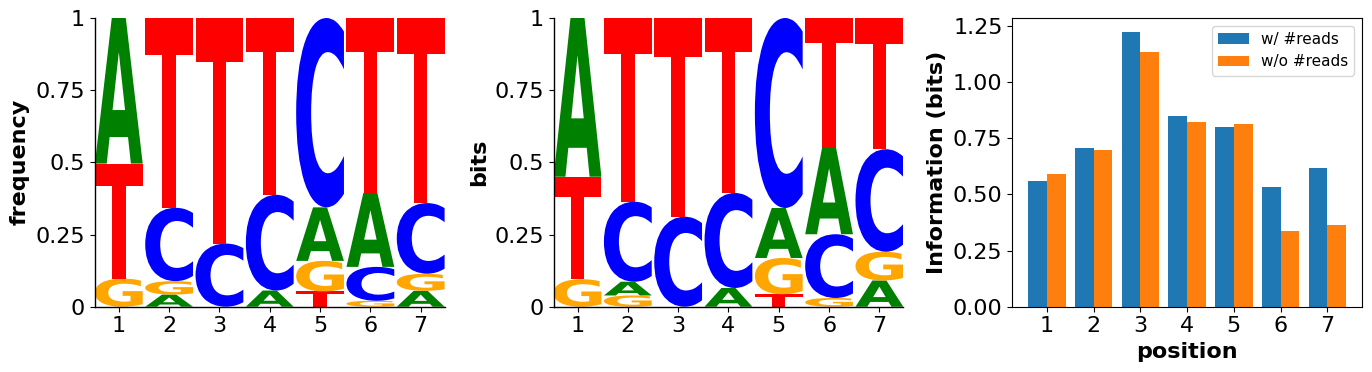

In [201]:
# Because of a bug with seqlogo in handling some specific situations, we used

# Use seqlogo to format PPM so as to represent weblogos
ppm_sel = seqlogo.Ppm(ord0_sel.T)
ppm_cnt = seqlogo.Ppm(ord0_cnt.T)

cpm_sel = seqlogo.CompletePm(ppm = ppm_sel, background = ord0_bck[0,:].T, pseudocount = 1e-10)
cpm_cnt = seqlogo.CompletePm(ppm = ppm_cnt, background = ord0_bck[0,:].T, pseudocount = 1e-10)


fig, ax = plt.subplots(1,3, figsize=(14,4))
# create Logo object
sel_logo = logomaker.Logo(ppm_sel.ppm, ax=ax[0], show_spines=True)#,
ax[0].set_ylabel('frequency', fontweight='bold')
ax[0].set_xticks([0,1,2,3,4,5,6])
ax[0].set_xticklabels(['1','2','3','4','5','6','7'])#, fontsize=11)
ax[0].set_yticks([0,0.25,0.5,0.75,1])
ax[0].set_yticklabels(['0','0.25','0.5','0.75','1'])#, fontsize=11)
sel_logo.style_spines(visible=False)
sel_logo.style_spines(spines=['left', 'bottom'], visible=True)

#for ind, val in enumerate(np.asarray(cpm_cnt.ic)):
#    ppm_cnt.ppm.iloc[ind,:] *= val

sel_logo = logomaker.Logo(ppm_cnt.ppm, ax=ax[1], show_spines=True)#,
ax[1].set_ylabel('bits', fontweight='bold')
ax[1].set_xticks([0,1,2,3,4,5,6])
ax[1].set_xticklabels(['1','2','3','4','5','6','7'])#, fontsize=11)
ax[1].set_yticks([0,0.25,0.5,0.75,1])
ax[1].set_yticklabels(['0','0.25','0.5','0.75','1'])#, fontsize=11)
sel_logo.style_spines(visible=False)
sel_logo.style_spines(spines=['left', 'bottom'], visible=True)

ax[2].bar(np.arange(1,8)-0.2, cpm_sel.ic, width=0.4, label='w/ #reads')
ax[2].bar(np.arange(1,8)+0.2, cpm_cnt.ic, width=0.4, label='w/o #reads')
ax[2].legend(fontsize=11)
ax[2].set_xlabel('position', fontweight='bold')
ax[2].set_xticks(np.arange(1,8))
ax[2].set_ylabel('Information (bits)', fontweight='bold')

fig.tight_layout()

## Fix natural nucleotide at each position

Visualize the influence of fixing one nucleotide (the one present in the natural sequence) at any given position on the frequency (first) and information content (second) at the other positions of the heptamer. The fixed nucleotide is shaded in grey.

#### Frequency logo plots

consensus : TCTCCTT
T 0 n= 82 / 35.5 %
C 1 n= 64 / 27.7 %
T 2 n= 159 / 68.8 %
C 3 n= 76 / 32.9 %
C 4 n= 152 / 65.8 %
T 5 n= 104 / 45.0 %
T 6 n= 105 / 45.5 %


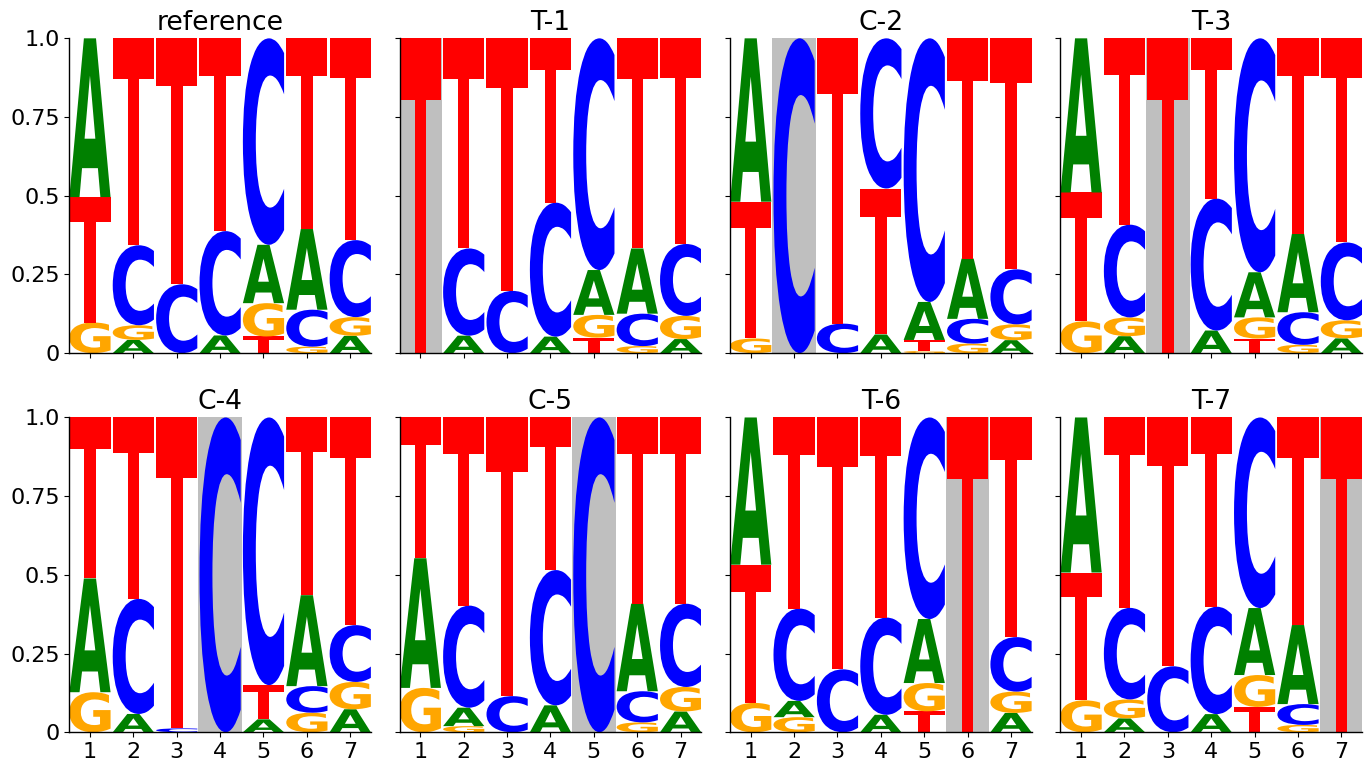

In [193]:
# 
consensusB = natSeqs[bank]
print("consensus :", consensusB)

monomers = ["A","C","G","T"]

fig, axes = plt.subplots(2,4, figsize=(14,8), sharex=True, sharey=True)
axs = axes.ravel()
# illustrate reference sequence logo
sel_logo = logomaker.Logo(ppm_ref.ppm, ax=axs[0], show_spines=True)#,
axs[0].set_xticks([0,1,2,3,4,5,6])
axs[0].set_xticklabels(['1','2','3','4','5','6','7'])
axs[0].set_yticks([0,0.5,1,1.5,2])
axs[0].set_yticklabels(['0','0.25','0.5','0.75','1'])
axs[0].set_title('reference')
sel_logo.style_spines(visible=False)
sel_logo.style_spines(spines=['left', 'bottom'], visible=True)
    
# Fix nuceotide at specified position
for pix, pp in enumerate(consensusB):
    ord0_sel = np.zeros((4,len(dfBank['sequence'].loc[0])))
    dfB = dfBank.loc[dfBank["before"]>=limCount]
    dfB = dfB.loc[dfB["after"]>=limCount]
    dfB = dfB.loc[dfB["ratio"]>=enrichThr]
    refNb = len(dfB)
    dfB = dfB[dfB[str(pix+1)]==pp]
    
    print(pp, str(pix), "n=", len(dfB), '/', np.round(100*len(dfB)/refNb, 1),'%')
    for ii in np.arange(7):
        for jj,nt in enumerate(monomers): 
            totAft = dfB['after'].loc[dfB[str(ii+1)]==nt].sum()
            ord0_sel[jj,ii] = totAft/dfB['after'].sum() 
    # Use seqlogo to format PPM so as to represent weblogos
    ppm_sel = seqlogo.Ppm(ord0_sel)
    cpm_sel = seqlogo.CompletePm(ppm = ppm_sel)

    sel_logo = logomaker.Logo(ppm_sel.ppm, ax=axs[pix+1], show_spines=True)#,
    axs[pix+1].set_xticks([0,1,2,3,4,5,6])
    axs[pix+1].set_xticklabels(['1','2','3','4','5','6','7'])
    axs[pix+1].set_yticks([0,0.25,0.5,0.75,1])
    axs[pix+1].set_yticklabels(['0','0.25','0.5','0.75','1.0'])
    axs[pix+1].set_title(pp+'-'+str(pix+1))
    sel_logo.style_spines(visible=False)
    sel_logo.style_spines(spines=['left', 'bottom'], visible=True)
    sel_logo.highlight_position(p=pix, color='grey', alpha=.5)

fig.tight_layout()

#### Entropy based logo plots (bits)

consensus : TCTCCTT
T 0 n= 82 / 35.5 %
C 1 n= 64 / 27.7 %
T 2 n= 159 / 68.8 %
C 3 n= 76 / 32.9 %
C 4 n= 152 / 65.8 %
T 5 n= 104 / 45.0 %
T 6 n= 105 / 45.5 %


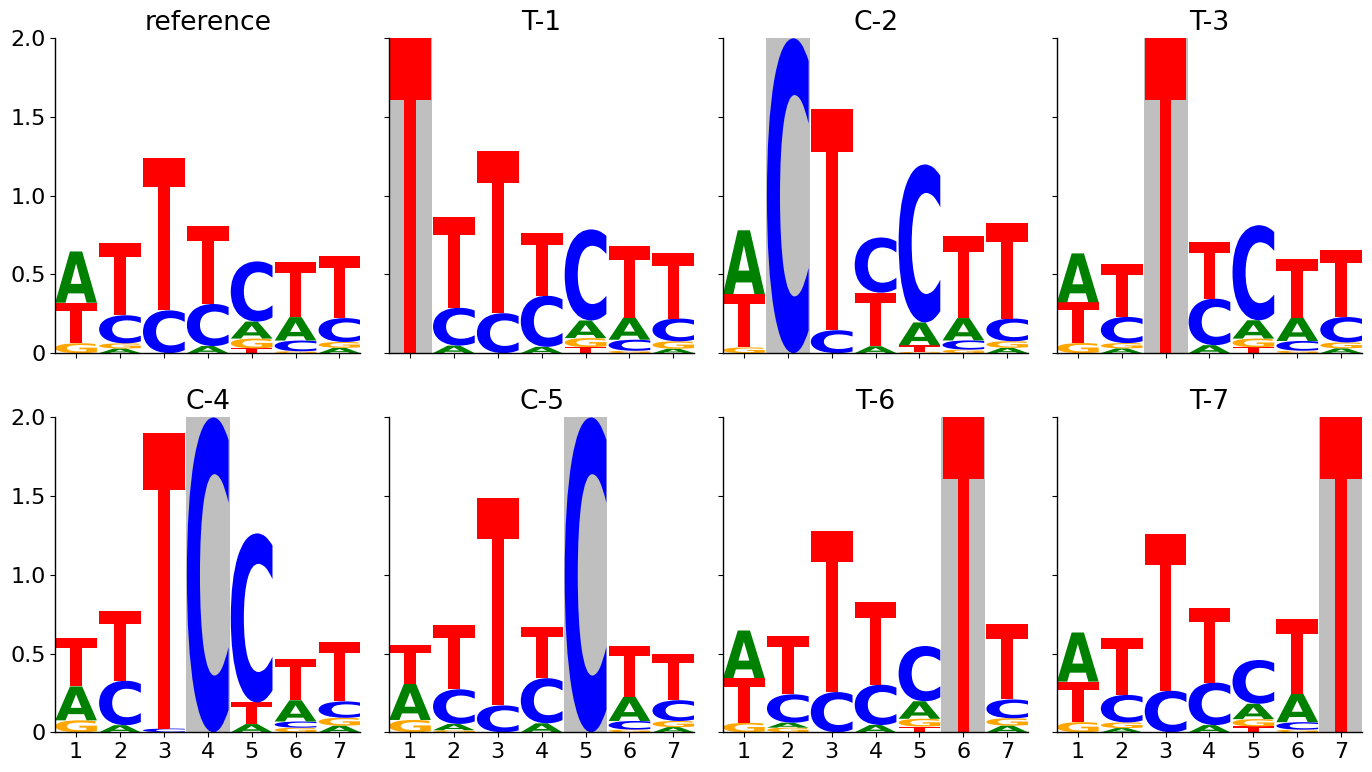

In [194]:
# Duplicate cell using logoMaker to generate plots
consensusB = natSeqs[bank]
print("consensus :", consensusB)

monomers = ["A","C","G","T"]

fig, axes = plt.subplots(2,4, figsize=(14,8), sharex=True, sharey=True)
axs = axes.ravel()
# illustrate reference sequence logo
sel_logo = logomaker.Logo(pim_ref, ax=axs[0], show_spines=True)#,
axs[0].set_xticks([0,1,2,3,4,5,6])
axs[0].set_xticklabels(['1','2','3','4','5','6','7'])
axs[0].set_yticks([0,0.5,1,1.5,2])
axs[0].set_yticklabels(['0','0.25','0.5','0.75','1'])
axs[0].set_title('reference')
sel_logo.style_spines(visible=False)
sel_logo.style_spines(spines=['left', 'bottom'], visible=True)
    
# Fix nuceotide at specified position
for pix, pp in enumerate(consensusB):
    ord0_sel = np.zeros((4,len(dfBank['sequence'].loc[0])))
    dfB = dfBank.loc[dfBank["before"]>=limCount]
    dfB = dfB.loc[dfB["after"]>=limCount]
    dfB = dfB.loc[dfB["ratio"]>=enrichThr]
    refNb = len(dfB)
    dfB = dfB[dfB[str(pix+1)]==pp]
    
    print(pp, str(pix), "n=", len(dfB), '/', np.round(100*len(dfB)/refNb, 1),'%')
    for ii in np.arange(7):
        for jj,nt in enumerate(monomers): 
            totAft = dfB['after'].loc[dfB[str(ii+1)]==nt].sum()
            ord0_sel[jj,ii] = totAft/dfB['after'].sum() 
    # Use seqlogo to format PPM so as to represent weblogos
    ppm_sel = seqlogo.Ppm(ord0_sel)
    cpm_sel = seqlogo.CompletePm(ppm = ppm_sel)
    for ind, val in enumerate(np.asarray(cpm_sel.ic)):
        ppm_sel.ppm.iloc[ind,:] *= val
    sel_logo = logomaker.Logo(ppm_sel.ppm, ax=axs[pix+1], show_spines=True)#,
    axs[pix+1].set_xticks([0,1,2,3,4,5,6])
    axs[pix+1].set_xticklabels(['1','2','3','4','5','6','7'])
    axs[pix+1].set_yticks([0,0.5,1,1.5,2])
    axs[pix+1].set_yticklabels(['0','0.5','1.0','1.5','2.0'])
    axs[pix+1].set_title(pp+'-'+str(pix+1))
    sel_logo.style_spines(visible=False)
    sel_logo.style_spines(spines=['left', 'bottom'], visible=True)
    sel_logo.highlight_position(p=pix, color='grey', alpha=.5)

fig.tight_layout()

## Fix enriched nucleotide at each position

Visualize the influence of fixing one nucleotide (the most prevalent one from the information content point of view) at any given position on the frequency (first) and information content (second) at the other positions of the heptamer. The fixed nucleotide is shaded in grey.

#### Frequency logo plots

consensus : ATTTCTT
A 0 n= 127 / 55.0 %
T 1 n= 147 / 63.6 %
T 2 n= 159 / 68.8 %
T 3 n= 140 / 60.6 %
C 4 n= 152 / 65.8 %
T 5 n= 104 / 45.0 %
T 6 n= 105 / 45.5 %


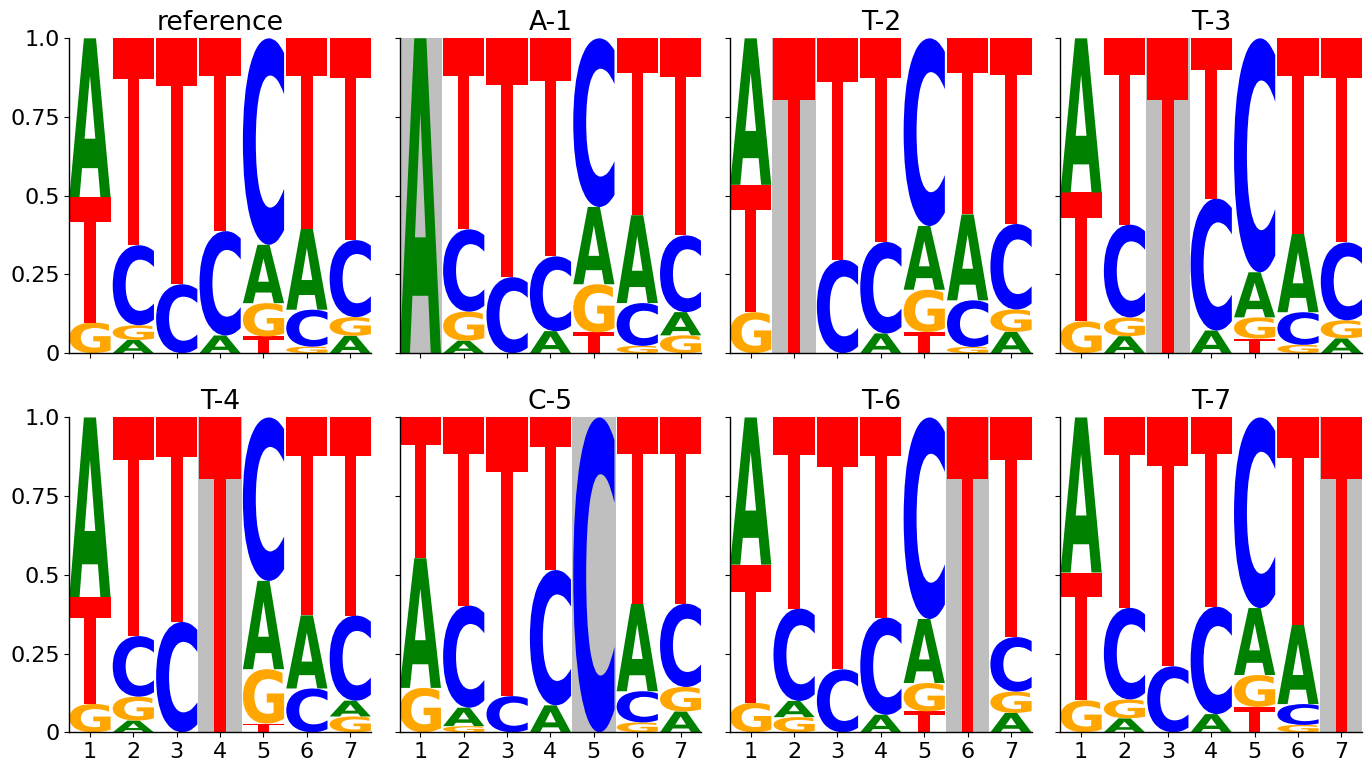

In [195]:
# 
consensusB = cpm_ref.consensus
print("consensus :", consensusB)

monomers = ["A","C","G","T"]

fig, axes = plt.subplots(2,4, figsize=(14,8), sharex=True, sharey=True)
axs = axes.ravel()
# illustrate reference sequence logo
sel_logo = logomaker.Logo(ppm_ref.ppm, ax=axs[0], show_spines=True)#,
axs[0].set_xticks([0,1,2,3,4,5,6])
axs[0].set_xticklabels(['1','2','3','4','5','6','7'])
axs[0].set_yticks([0,0.5,1,1.5,2])
axs[0].set_yticklabels(['0','0.25','0.5','0.75','1'])
axs[0].set_title('reference')
sel_logo.style_spines(visible=False)
sel_logo.style_spines(spines=['left', 'bottom'], visible=True)
    
# Fix nuceotide at specified position
for pix, pp in enumerate(consensusB):
    ord0_sel = np.zeros((4,len(dfBank['sequence'].loc[0])))
    dfB = dfBank.loc[dfBank["before"]>=limCount]
    dfB = dfB.loc[dfB["after"]>=limCount]
    dfB = dfB.loc[dfB["ratio"]>=enrichThr]
    refNb = len(dfB)
    dfB = dfB[dfB[str(pix+1)]==pp]
    
    print(pp, str(pix), "n=", len(dfB), '/', np.round(100*len(dfB)/refNb, 1),'%')
    for ii in np.arange(7):
        for jj,nt in enumerate(monomers): 
            totAft = dfB['after'].loc[dfB[str(ii+1)]==nt].sum()
            ord0_sel[jj,ii] = totAft/dfB['after'].sum() 
    # Use seqlogo to format PPM so as to represent weblogos
    ppm_sel = seqlogo.Ppm(ord0_sel)
    cpm_sel = seqlogo.CompletePm(ppm = ppm_sel)

    sel_logo = logomaker.Logo(ppm_sel.ppm, ax=axs[pix+1], show_spines=True)#,
    axs[pix+1].set_xticks([0,1,2,3,4,5,6])
    axs[pix+1].set_xticklabels(['1','2','3','4','5','6','7'])
    axs[pix+1].set_yticks([0,0.25,0.5,0.75,1])
    axs[pix+1].set_yticklabels(['0','0.25','0.5','0.75','1.0'])
    axs[pix+1].set_title(pp+'-'+str(pix+1))
    sel_logo.style_spines(visible=False)
    sel_logo.style_spines(spines=['left', 'bottom'], visible=True)
    sel_logo.highlight_position(p=pix, color='grey', alpha=.5)

fig.tight_layout()

#### Entropy based logo plots (bits)

consensus : ATTTCTT
A 0 n= 127 / 55.0 %
T 1 n= 147 / 63.6 %
T 2 n= 159 / 68.8 %
T 3 n= 140 / 60.6 %
C 4 n= 152 / 65.8 %
T 5 n= 104 / 45.0 %
T 6 n= 105 / 45.5 %


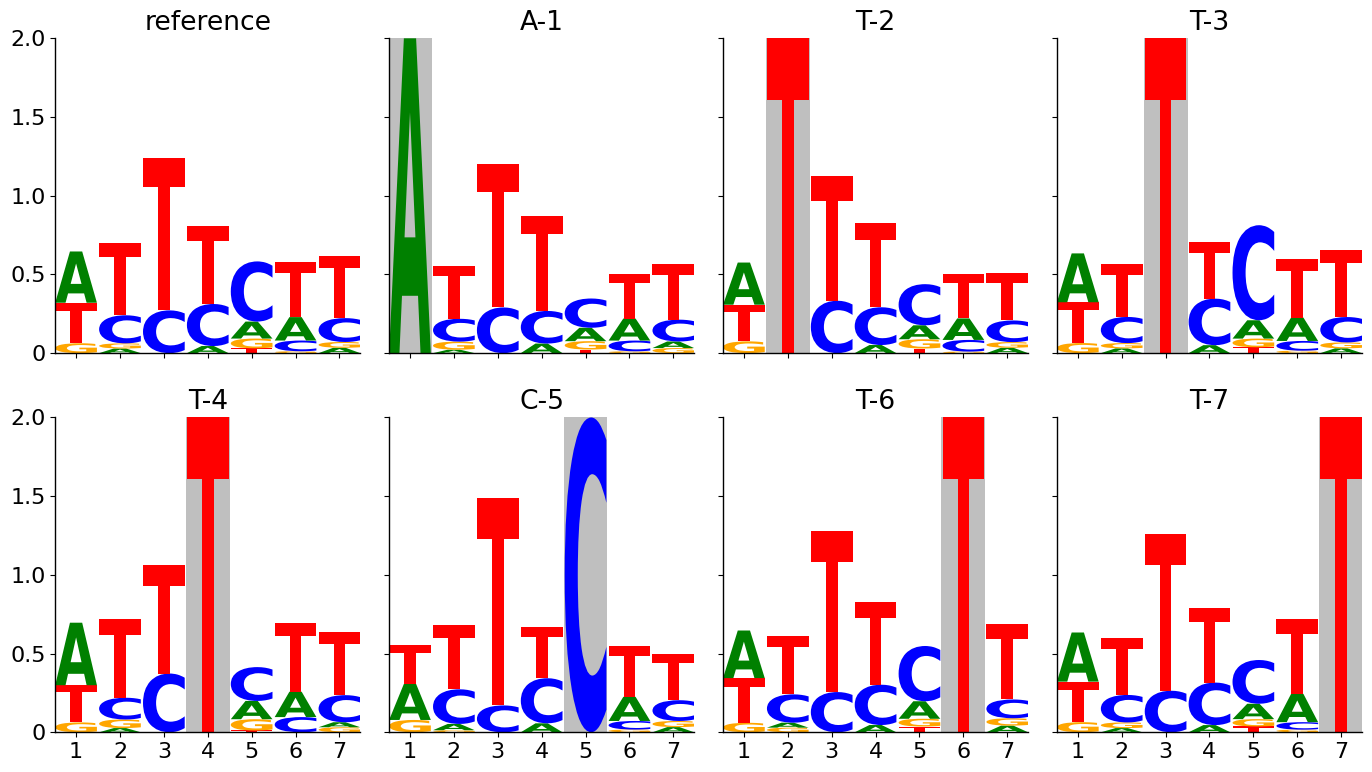

In [196]:
# 
consensusB = cpm_sel.consensus
print("consensus :", consensusB)

monomers = ["A","C","G","T"]

fig, axes = plt.subplots(2,4, figsize=(14,8), sharex=True, sharey=True)
axs = axes.ravel()
# illustrate reference sequence logo
sel_logo = logomaker.Logo(pim_ref, ax=axs[0], show_spines=True)#,
axs[0].set_xticks([0,1,2,3,4,5,6])
axs[0].set_xticklabels(['1','2','3','4','5','6','7'])
axs[0].set_yticks([0,0.5,1,1.5,2])
axs[0].set_yticklabels(['0','0.25','0.5','0.75','1'])
axs[0].set_title('reference')
sel_logo.style_spines(visible=False)
sel_logo.style_spines(spines=['left', 'bottom'], visible=True)
    
# Fix nuceotide at specified position
for pix, pp in enumerate(consensusB):
    ord0_sel = np.zeros((4,len(dfBank['sequence'].loc[0])))
    dfB = dfBank.loc[dfBank["before"]>=limCount]
    dfB = dfB.loc[dfB["after"]>=limCount]
    dfB = dfB.loc[dfB["ratio"]>=enrichThr]
    refNb = len(dfB)
    dfB = dfB[dfB[str(pix+1)]==pp]
    
    print(pp, str(pix), "n=", len(dfB), '/', np.round(100*len(dfB)/refNb, 1),'%')
    for ii in np.arange(7):
        for jj,nt in enumerate(monomers): 
            totAft = dfB['after'].loc[dfB[str(ii+1)]==nt].sum()
            ord0_sel[jj,ii] = totAft/dfB['after'].sum() 
    # Use seqlogo to format PPM so as to represent weblogos
    ppm_sel = seqlogo.Ppm(ord0_sel)
    cpm_sel = seqlogo.CompletePm(ppm = ppm_sel)
    for ind, val in enumerate(np.asarray(cpm_sel.ic)):
        ppm_sel.ppm.iloc[ind,:] *= val
    sel_logo = logomaker.Logo(ppm_sel.ppm, ax=axs[pix+1], show_spines=True)#,
    axs[pix+1].set_xticks([0,1,2,3,4,5,6])
    axs[pix+1].set_xticklabels(['1','2','3','4','5','6','7'])
    axs[pix+1].set_yticks([0,0.5,1,1.5,2])
    axs[pix+1].set_yticklabels(['0','0.5','1.0','1.5','2.0'])
    axs[pix+1].set_title(pp+'-'+str(pix+1))
    sel_logo.style_spines(visible=False)
    sel_logo.style_spines(spines=['left', 'bottom'], visible=True)
    sel_logo.highlight_position(p=pix, color='grey', alpha=.5)

fig.tight_layout()

## Position specific pair frequencies

Compare the frequencies of nucleotide pairs with expected frequencies. The expected frequencies are based on the hypothesis that there is no pairwise preference between nucleotides at each pair of position.

Say, there are 50% A, 50% T at position 1 and 50% C, 50% G at position 2. Based on the expectation of random association between pairs of positions, you would expect 25% of each pair AC, AG, TC & TG. Using Cramer's V, one can calculate how unexpected it is to observe 50% AC and 50 %TG. In this very unexpected situation where all A at position 1 are always associated with C at position 2, Cramer's V is high. There are preferential $A_1C_2$ and $T_1G_2$ associations.

Let's see what happens with our collection of heptamers:

List pairs of positions with non-random association (based on high Cramer's V values)

In [197]:
# Subset

dfB = dfBank.loc[dfBank["before"]>=limCount]
dfB = dfB.loc[dfB["after"]>=limCount]
dfB = dfB.loc[dfB["ratio"]>=enrichThr]

CrV = np.zeros((7,7))

Chi2_list = []
for ii in np.arange(0,6):
    for jj in np.arange(ii+1,7):
        expected = pd.crosstab(dfBank[str(ii+1)], dfBank[str(jj+1)], dfBank['before'], aggfunc = sum)
        Xtable = pd.crosstab(dfB[str(ii+1)], dfB[str(jj+1)], dfB['after'], aggfunc = sum) #/dfB['after'].sum()
        chi2, p, dof, ex = scs.chi2_contingency(Xtable.fillna(0), correction=False)
        cramesVe, _ = cramers_v(expected.fillna(0), verbose=False)
        cramesVx, dof = cramers_v(Xtable.fillna(0), verbose=False)
        CrV[ii,jj] = cramesVx
        if (np.absolute(cramesVx)>0.2) & (p<0.05/21):
            Chi2_list.append([ii+1,jj+1, cramesVe, cramesVx, dof])
#print("position1, position2, Cramer's V background, Cramer's V (>0.11 only), DoF")
bilan = pd.DataFrame(Chi2_list, columns=["position1", "position2", "Cramer's V background",
                                         "Cramer's V", "Degree of freedom"])
bilan.style \
  .set_caption('Position pairs with Cramer''s V > 0.2 AND Chi2 test p-value < 0.0024\n'+
              '(Bonferroni corrected at a 5% threshold)')
#Chi2_list
#bilan

,position1,position2,Cramer's V background,Cramer's V,Degree of freedom
0,1,5,0.008337,0.203884,2
1,2,3,0.020759,0.267007,1
2,3,4,0.018056,0.400487,1
3,3,5,0.013714,0.358316,1
4,4,5,0.021232,0.332503,2


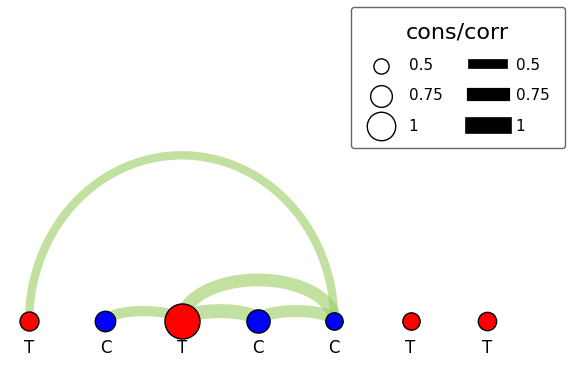

In [198]:
f,ax = chordDiagram(natSeqs[bank], pos_ic, CrV)